In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import os
from scipy.spatial import KDTree
metro = pd.read_csv("lineas-y-estaciones-del-metro.csv")
metrobus = pd.read_csv("estaciones-metrobus.csv")
# parse json data to dicts
metro["Geo Shape"] = [json.loads(m) for m in metro["Geo Shape"]]
metrobus["Geo Shape"] = [json.loads(m) for m in metrobus["Geo Shape"]]
metro = metro.rename(columns={"Nombre":"nombre"})

In [2]:
def separateLines(df):
    index = np.array([df.loc[i,"Geo Shape"]["type"]=="MultiLineString" for i in range(df.shape[0])])
    return df[index].reset_index(), df[~index].reset_index()

In [3]:
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [4]:
def getCoordinates(edge,df):
    coord1 = np.array(df[df["nombre"]==edge[0]]["Geo Shape"].iloc[0]["coordinates"])
    coord2 = np.array(df[df["nombre"]==edge[1]]["Geo Shape"].iloc[0]["coordinates"])
    return coord1, coord2
def earthDist(coord1,coord2):
    coord1 = np.pi/180*coord1
    coord2 = np.pi/180*coord2
    a = np.sin((coord1[1]-coord2[1])/2)**2 + np.cos(coord1[1])*np.cos(coord2[1])*np.sin((coord1[1]-coord2[1])/2)**2
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return c*6371000

In [5]:
A = [1,2,3]
A.extend(reversed(A))
print(A)

[1, 2, 3, 3, 2, 1]


In [6]:
def getLines(df):
    lineas, estaciones = separateLines(df)
    tree = KDTree(np.array([x["coordinates"][0:2] for x in estaciones["Geo Shape"]]))
    full_stat = []
    full_dists = []
    for index,row in lineas.iterrows():
        enlaces = row["Geo Shape"]["coordinates"][0]
        print()
        print("Processing ", end="")
        print(row["nombre"])
        stat = []
        for i in range(len(enlaces)):
            edge = tree.query(enlaces[i],p=np.inf)
            ind = edge[1]
            stat.append(estaciones.loc[ind,"nombre"])
        stat_clean = unique(stat)
        # correction for metro, linea 3
        if row["nombre"]=="Línea 3":
            stat_clean.insert(9,"Centro Médico_1")
            stat_clean.insert(9,"Centro Médico_1")
        # correction for metro, linea 12
        elif row["nombre"]=="Línea 12":
            stat_clean.insert(18,"Zapotitlán")
        # correction for metrobus, linea 4
        elif "MB04-A" in row["nombre"]:
            stat_clean=["San Lázaro","Archivo General de la Nación","Aeropuerto T1", "Aeropuerto T2","Archivo General de la Nación"]
        print("Stations found:")
        print(stat_clean)
        print()
        edges = list(zip(stat_clean[:-1],stat_clean[1:]))
        dists = []
        for edge in edges:
            coord1, coord2 = getCoordinates(edge,df)
            dists.append(round(earthDist(coord1,coord2)))
        full_dists.extend(dists)
        full_stat.extend(edges)
    return full_stat, full_dists

In [7]:
edges_metrobus,dists_metrobus = getLines(metrobus)
edges_metro,dists_metro = getLines(metro)


Processing MB07-A (Indios Verdes - Campo Marte)
Stations found:
['Indios Verdes', 'De Los Misterios', 'La Villa', 'Garrido', 'Av. Talismán', 'Necaxa', 'Excélsior', 'Robles Domínguez', 'Clave', 'Misterios', 'Mercado Beethoven', 'Peralvillo', 'Tres Culturas', 'Glorieta Cuitláhuac', 'Garibaldi', 'Glorieta Violeta', 'Hidalgo', 'El Caballito', 'Glorieta de Colón', 'París', 'Reforma', 'Hamburgo', 'La Palma', 'El Ángel', 'La Diana', 'Chapultepec', 'Gandhi', 'Antropología', 'Auditorio', 'Campo Marte']


Processing MB05-A (Remedios - San Lazaro)
Stations found:
['Río de Los Remedios', '314', '5 de Mayo', 'Vasco de Quiroga', 'El Coyol', 'Preparatoria 3', 'San Juan de Aragón', 'Río de Guadalupe', 'Talismán', 'Victoria', 'Oriente 101', 'Río Santa Coleta', 'Río Consulado', 'Canal del Norte', 'Deportivo Eduardo Molina', 'Mercado Morelos', 'Archivo General de la Nación', 'San Lázaro', 'Moctezuma']


Processing MB07-C (Glorieta Cuitlahuac - Campo Marte)
Stations found:
['Glorieta Cuitláhuac', 'Gariba

In [8]:
def processString(string):
    if " / " in string:
        string = string.split(" / ")[0]
    dic = {"á":"a",
    "é":"e",
    "í":"i",
    "ó":"o",
    "ú":"u",
    "ü":"u",
    " ":"_"}
    string = string.lower()
    for val in dic.items():
        string = string.replace(val[0],val[1])
    return string

In [9]:
edges_metro = [(processString(var[0].split("_")[0]),processString(var[1].split("_")[0])) for var in edges_metro]
edges_metrobus = [(processString(var[0].split("_")[0]),processString(var[1].split("_")[0])) for var in edges_metrobus]

In [10]:
estaciones_metro = set([x for edge in edges_metro for x in edge])
estaciones_metrobus = set([x for edge in edges_metrobus for x in edge])
coincidencias = estaciones_metro.intersection(estaciones_metrobus)

In [11]:
f = open("falsas_coincidencias.txt","r")
falsas_coincidencias =[]
for line in f:
    falsas_coincidencias.append(line.replace("\n",""))
f.close()

In [12]:
E = [edges_metrobus,edges_metro]
C = ["metrobus_","metro_"]
for j in range(len(E)):
    for i,edge in enumerate(E[j]):
        if (edge[0] in falsas_coincidencias) and (edge[1] in falsas_coincidencias):
            E[j][i] = (C[j]+edge[0],C[j]+edge[1])
        elif (edge[0] in falsas_coincidencias):
            E[j][i] = (C[j]+edge[0],edge[1])
        elif (edge[1] in falsas_coincidencias):
            E[j][i] = (edge[0],C[j]+edge[1])

In [13]:
estaciones_metro = set([x for edge in edges_metro for x in edge])
estaciones_metrobus = set([x for edge in edges_metrobus for x in edge])
coincidencias = estaciones_metro.intersection(estaciones_metrobus)

In [14]:
edges_metro_inv = [(edg[1],edg[0]) for edg in edges_metro]

In [15]:
edges = edges_metro +  edges_metro_inv + edges_metrobus
dists = dists_metro + dists_metro + dists_metrobus
unzipped = list(zip(*edges))
df = pd.DataFrame.from_dict({"source":unzipped[0],"dest":unzipped[1],"dist":dists})
G = nx.from_pandas_edgelist(df,source="source",target="dest",edge_attr=["dist"],create_using=nx.DiGraph)
nx.write_gexf(G,"metro-metrobus.gexf")

In [16]:
unzipped = list(zip(*edges_metrobus))
df = pd.DataFrame.from_dict({"source":unzipped[0],"dest":unzipped[1],"dist":dists_metrobus})
G2 = nx.from_pandas_edgelist(df,source="source",target="dest",edge_attr=["dist"],create_using=nx.DiGraph)
nx.write_gexf(G2,"metrobus.gexf")

In [17]:
A = sorted(nx.degree_centrality(G).items(),key=lambda x : x[1])

In [18]:
def degree(G):
    return dict(G.degree())
def distances(G):
    return {(x[0],x[1]):x[2] for x in G.edges.data("dist")}

In [19]:
G.name="metro-metrobus"
G2.name="metrobus"

In [20]:
import sys
#sys.path.append('C:\\Users\\sayeg\\Insync\\sayeg@ciencias.unam.mx\\Google Drive\\Backup\\Maestria\\2021-1\\complejos\\sistemas_complejos2021-1')
sys.path.append("..")
import graficas_ayuda as ga

calculating degree
calculating clustering
calculating distances
calculating distances
calculating closeness_centrality
calculating betweenness_centrality
calculating eigenvector_centrality_numpy
calculating pagerank_numpy
calculating degree
calculating clustering
calculating distances
calculating distances
calculating closeness_centrality
calculating betweenness_centrality
calculating eigenvector_centrality_numpy
calculating pagerank_numpy


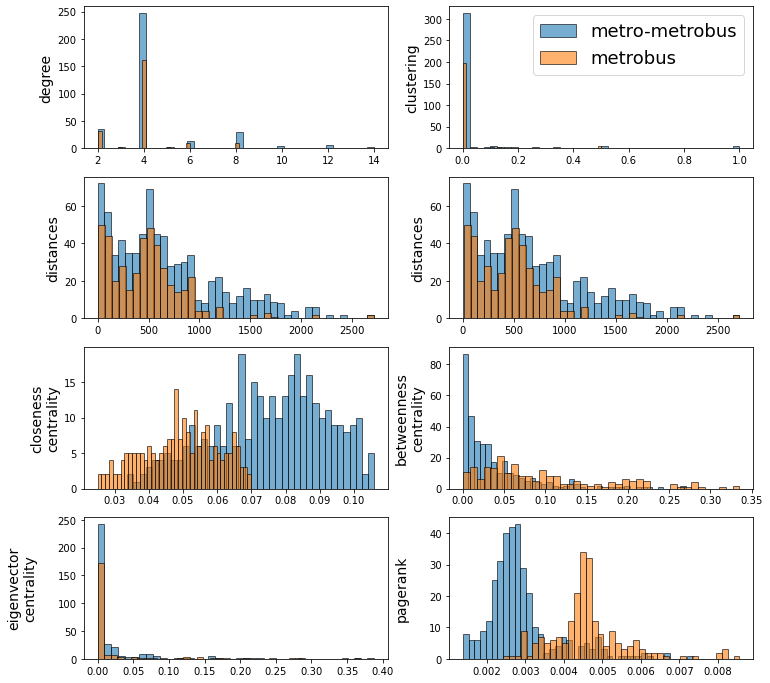

In [25]:
funcs =  [degree,nx.clustering,distances,distances,nx.closeness_centrality,nx.betweenness_centrality,nx.eigenvector_centrality_numpy,nx.pagerank_numpy]
rows = int(np.ceil(len(funcs)/2))
fig,axs = plt.subplots(nrows=rows,ncols=2,figsize=(12,12))
ga.plotStatistics(G,funcs,axs,vals = [f(G) for f in funcs])
ga.plotStatistics(G2,funcs,axs)
plt.show()